# [마스코트 생성기 제작] Huggingface Diffuers 이용 Stable Diffusion 파인튜닝

* [주의] 파인튜닝 학습 부분은 T4로 했을시 RAM 터짐 발생 - 최소 L4 권장
* PyTorch 기반


### 셋업

In [1]:
!pip install transformers datasets diffusers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 35.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 M

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import transforms
import transformers, datasets, diffusers
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from diffusers.optimization import get_scheduler

from tqdm import tqdm
from PIL import Image

In [3]:
transformers.__version__, datasets.__version__, diffusers.__version__

('4.41.2', '2.20.0', '0.29.2')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 데이터 다운로드

https://huggingface.co/datasets/Suriring/mascot_dataset?library=datasets

In [20]:
from datasets import load_dataset

# 허깅페이스에 업로드한 마스코트 이미지-텍스트 pair 데이터셋 다운로드
dataset = load_dataset("Suriring/mascot_dataset")

Generating train split:   0%|          | 0/1865 [00:00<?, ? examples/s]

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 1865
    })
})

In [22]:
dataset['train'][0]

{'image': <PIL.WebPImagePlugin.WebPImageFile image mode=RGB size=749x562>,
 'text': "**Part 1:** The image depicts a cheerful, dough-like character with a big smile and blue eyes, wearing a chef's hat and a scarf. The character has one arm raised in a friendly wave.\n\n**Part 2:** Trustworthiness, approachability, and joyfulness."}

### 데이터 확인

(336, 449)
**Part 1:** The image depicts a cute, yellow, round-headed character holding two soccer balls, one larger and one smaller. The character has a smiling face with rosy cheeks and is winking with one eye.

**Part 2:** 
1. Playfulness
2. Sportsmanship
3. Positivity


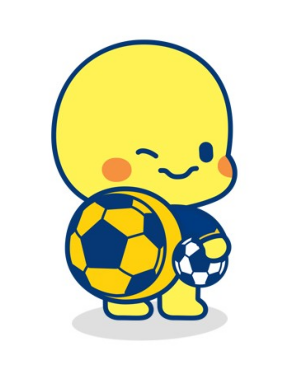

In [39]:
# 이미지랑 텍스트 확인해보기

def data_visualize(i):
    idx = i
    print(dataset['train'][idx]['image'].size)
    print(dataset['train'][idx]['text'])
    plt.imshow(np.array(dataset['train'][idx]['image']))
    plt.axis(False)
    plt.show()

data_visualize(1600)

(304, 330)
Part 1: The image depicts a cute, round character with a white body and an orange hood with cat-like ears. It has a cheerful expression, with blushing cheeks and a tuft of yellow hair.

Part 2: 
1. Friendliness
2. Approachability
3. Positivity


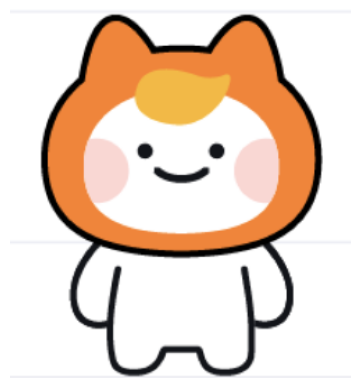

In [41]:
data_visualize(360)

## 필요 모델 로딩

- 노이즈 스케쥴러, 텍스트 토크나이저, 텍스트 인코더, 이미지 오토인코더, unet 모델을 선학습된 상태로 각각 로딩

In [58]:
PRE_TRAINED_MODEL_NAME="runwayml/stable-diffusion-v1-5"

noise_scheduler = DDPMScheduler.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="scheduler"
)

tokenizer = CLIPTokenizer.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="tokenizer"
)

# 학습 파라미터 있으나 고정될 것임
text_encoder = CLIPTextModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="text_encoder"
)

# 학습 파라미터 있으나 고정될 것임
vae = AutoencoderKL.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="vae"
)

# 학습 파라미터 있고 파인튜닝 될 것임
unet = UNet2DConditionModel.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    subfolder="unet"
)

## 데이터 전처리

### 텍스트 전처리

- 샘플에 로딩된 토크나이저를 적용해 문장을 모두 정수 토큰 아이디로 바꿈

In [59]:
# 모델에 입력되는 최대 토큰 길이
tokenizer.model_max_length

77

In [60]:
# 토크나이징 테스트
tokenizer(dataset['train'][idx]['text'],
          max_length=tokenizer.model_max_length,
          padding='max_length',
          truncation=True,
          return_tensors='pt')

{'input_ids': tensor([[49406,  4441,  1551,   272,    25,  4441,   518,  2867, 29340,   320,
          2242,   267,  4481,   267,  2522,   268,  6153,  4009,  5050,  1237,
          4233,  6927,   267,   637, 12567,   537,   637, 12431,   269,   518,
          4009,   791,   320,  9200,  1710,   593, 46705, 23019,   537,   533,
           831,   674,   593,   637,  3272,   269,  4441,  1551,   273,    25,
          4441,   272,   269,  1222, 10526,   273,   269, 34858,   274,   269,
         19966, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [61]:
# 데이터 셋의 한 샘플에 대해서 text컬럼을 토크나이징 해서 되돌리는 함수
def tokenize_captions(examples, caption_column='text', is_train=True):
    captions = []

    for caption in examples[caption_column]:
        # 캡션이 하나인 경우
        if isinstance(caption, str):
            captions.append(caption)
        # 캡션이 하나 이상인 경우 아무거나 하나 선택
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )

    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )

    return inputs.input_ids

### 이미지 전처리

- 특별한것 없고 그냥 pytorch에서 제공하는 이미지 증강 기능을 사용

In [62]:
IMG_SIZE = 512
CENTER_CROP = True
RANDOM_FLIP = True

In [63]:
# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(IMG_SIZE) if CENTER_CROP else transforms.RandomCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip() if RANDOM_FLIP else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]), # (0,1)->(-1,1)
    ]
)

### 종합 처리 함수

- 모든 샘플에 대해서 텍스트, 이미지 전처리 함수를 적용할 함수

In [64]:
def preprocess_train(examples, image_column='image'):
    images = [image.convert("RGB") for image in examples[image_column]]

    # 이미지 전처리
    examples["pixel_values"] = [train_transforms(image) for image in images]

    # 텍스트 전처리
    examples["input_ids"] = tokenize_captions(examples)

    return examples

## 데이터 로더

In [65]:
def collate_fn(examples):
    # (C, H, W), ..., (C, H, W) -> stack -> (N, C, H, W): N으로 스택
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # tensor.contiguous()와 동일
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    # {(77,), ..., (77,)}_N개 -> stack -> (N, 77)
    input_ids = torch.stack([example["input_ids"] for example in examples])

    return {"pixel_values": pixel_values, "input_ids": input_ids}

In [66]:
# 데이터 실시간 변환 적용
train_dataset = dataset["train"].with_transform(preprocess_train)

In [67]:
# 데이터 컬럼을 확인하면 이시점까지는
# 'image', 'text'만 있고 pixel_values, input_ids 없음
train_dataset.column_names

['image', 'text']

In [68]:
# 실시간으로 적용되기 때문에 데이터셋 컬럼에는 변환 결과 컬럼이 없고
# 데이터를 가져와야 보임
train_dataset[0].keys()

dict_keys(['image', 'text', 'pixel_values', 'input_ids'])

In [69]:
# 데이터로더 생성

BATCH_SIZE = 2 # 2 for rtx 3090
NUM_WORKERS = 4 # 4 for rtx 3090

# DataLoaders creation:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

In [70]:
# 데이터로더 테스트
train_dataloader_iter = iter(train_dataloader)
mini_batch = next(train_dataloader_iter)

# 이미지 데이터,                  캡션 데이터
mini_batch['pixel_values'].shape, mini_batch['input_ids'].shape

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(torch.Size([2, 3, 512, 512]), torch.Size([2, 77]))

In [71]:
# 데이터로더의 이터레이션 수
len(train_dataloader)

933

In [72]:
# 참고 text_encoder의 출력
# BaseModelOutputWithPooling 이 되돌려지는데 [0]이 last_hidden_state
# 트랜스포머 인코더의 마지막 히든층 츨력이므로 크기는 (batch size, time step, model dim)
text_encoder(mini_batch['input_ids'])[0].shape

torch.Size([2, 77, 768])

## 모델 준비

In [73]:
# FP16을 AMP으로 적용하기 위한 세팅

# weight_dtype = torch.float32
weight_dtype = torch.float16 # half precision

In [74]:
# vae와 텍스트 인코더는 미세조정에서 학습되지 않음
vae.requires_grad_(False);
text_encoder.requires_grad_(False);

In [75]:
# Move text_encode and vae to gpu
text_encoder.to(device);
vae.to(device);
unet.to(device);

unet.train();

## 옵티마이저 & 학습률 스케쥴러

In [76]:
EPOCHS = 20
LEARNING_RATE = 1e-05

optimizer = torch.optim.AdamW(
        unet.parameters(),
        lr=LEARNING_RATE,
    )

In [77]:
lr_scheduler = get_scheduler(
        'linear',
        optimizer=optimizer,
        num_warmup_steps=500,
        num_training_steps=EPOCHS * len(train_dataloader)
    )

In [ ]:
# BaseModelOutputWithPooling 이 되돌려지는데 [0]이 last_hidden_state
# 트랜스포머 인코더의 마지막 히든층 츨력이므로 크기는 (N, T, D)

## 학습 루프

In [78]:
# 학습 요소들의 세팅값 확인

noise_scheduler.config.prediction_type, vae.config.scaling_factor

('epsilon', 0.18215)

In [ ]:
# AMP
#  - True: 2m30s(RTX3090)/epoch, 1m50s(A100)/epoch
#  - False: 4m30s/epoch(RTX3090)

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
prediction_type = None # 'epsilon'  or 'v_prediction'

train_losses = []

for epoch in range(EPOCHS):
    for step, batch in enumerate(tqdm(train_dataloader)):
        # T4에서 amp autocast가 호환이 안됨
        # sm==80 || sm==90 관련 에러가 뜨면 pytorch 2.0으로 다운 그레이드 하면됨
        # 또는 임시로 이렇게하면 되는데
        # 해당 오류를 없애더라도 어차피 T4에서는 OOM 떠서 학습 안됨
        # A100 또는 개인 로컬 20기가 이상 GPU 사용해야 됨
        # https://github.com/pytorch/pytorch/issues/94883
        # with torch.autocast(device_type=device, dtype=weight_dtype, enabled=use_amp) as autocast, \
        # torch.backends.cuda.sdp_kernel(enable_flash=False) as disable :
        with torch.autocast(device_type=device, dtype=weight_dtype, enabled=use_amp):
            latents = vae.encode(
                batch["pixel_values"].to(device)
            ).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            noise = torch.randn_like(latents)

            bsz = latents.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            encoder_hidden_states = text_encoder(batch["input_ids"].to(device) )[0]

            # 노이즈 스케쥴러에 예측 타입이 노이즈인지 이미지인지에 따라 타겟 설정
            if prediction_type is not None:
                noise_scheduler.register_to_config(prediction_type=prediction_type)

            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")


        with torch.no_grad():
            train_losses.append(loss.item())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        optimizer.zero_grad()

    #  loss값 확인
    avg_loss = sum(train_losses[-100:])/100
    print(f'Finished epoch {epoch+1}. Average of the last 100 loss values: {avg_loss:05f}')


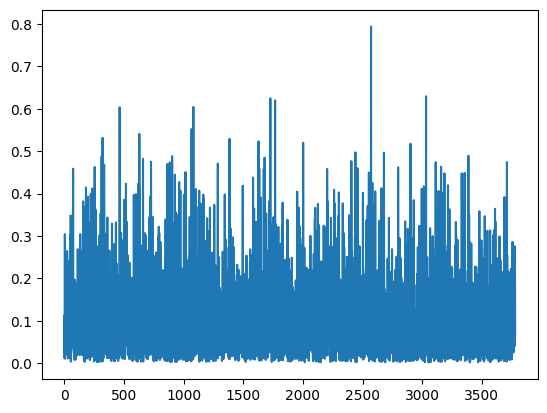

In [ ]:
plt.plot(train_losses)
plt.show()

## 이미지 생성
파이프라인 사용

In [6]:
from diffusers import StableDiffusionPipeline

In [7]:
pipeline = StableDiffusionPipeline.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    text_encoder=text_encoder,
    vae=vae,
    unet=unet, # 미세 조정된 네트워크
)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
pipeline.to(device);

## 학습된 모델 파이프라인 저장, 이미지 생성

### push to Hub

In [79]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
pipeline.push_to_hub("stable-diffusion-v1-5-finetune-mascot_240612")

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/metamath/stable-diffusion-v1-5-finetune-pokemon-blip/commit/531b56110a7dbf0fe7c9cb89b5c9843107599d99', commit_message='Upload StableDiffusionPipeline', commit_description='', oid='531b56110a7dbf0fe7c9cb89b5c9843107599d99', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
pipeline = DiffusionPipeline.from_pretrained("Suriring/stable-diffusion-v1-5-finetune-mascot_240612")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipeline.to(device);

  0%|          | 0/50 [00:00<?, ?it/s]

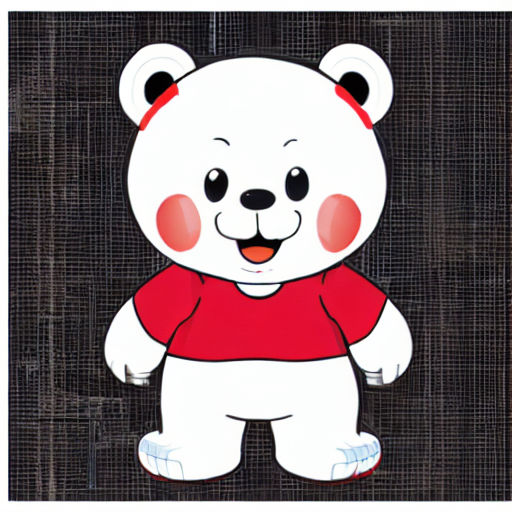

In [ ]:
pipeline_output = pipeline(["""
part 1 **
Generate a very cute teddybear-like trendy mascot image. Its body is white and it has point color in red. It reperesents a company related to big data analysis, so it should look smart and happy.

part 2 **
1.friendliness  2. innovation  3. analytical
"""])
pipeline_output.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

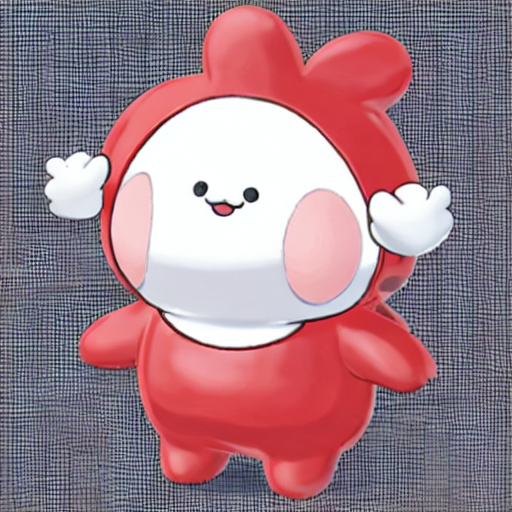

In [ ]:
pipeline_output = pipeline(["""
part 1 **
Generate a very cute snowman-like trendy mascot image. Its body is white and it has point color in red. It reperesents a company related to big data analysis, so it should look smart and happy.

part 2 **
1. friendliness  2. innovation  3. analytical
"""])
pipeline_output.images[0]

### 팀원이 포켓몬 데이터로 추가학습한 모델 불러오기

In [81]:
!pip install diffusers
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("Suriring/stable-diffusion-v1-5-finetune-mascot_240613")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

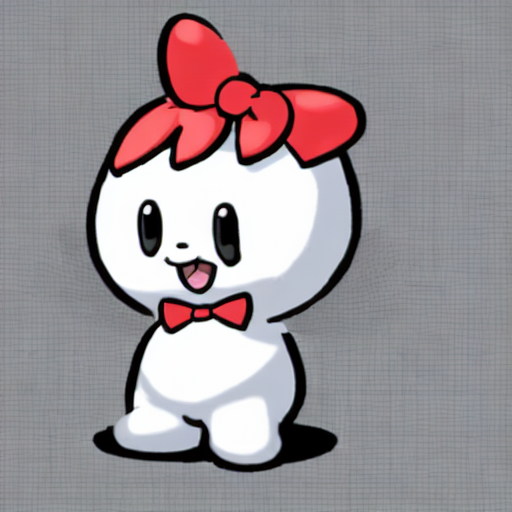

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipeline.to(device);

pipeline_output = pipeline(["""
part 1 **
Generate a very cute snowman-like trendy mascot image. Its body is white and it has point color in red. It reperesents a company related to big data analysis, so it should look smart and happy.

part 2 **
1. friendliness  2. innovation  3. analytical
"""])
pipeline_output.images[0]

Token indices sequence length is longer than the specified maximum sequence length for this model (123 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['members logo, making it recognizable and associated with the brand. this cute mascot is in 3 main colors - white, # 0 0 9 bfa, # d 3 1 c 2 b! part 2 : trustworthy, smart, loyal']


  0%|          | 0/50 [00:00<?, ?it/s]

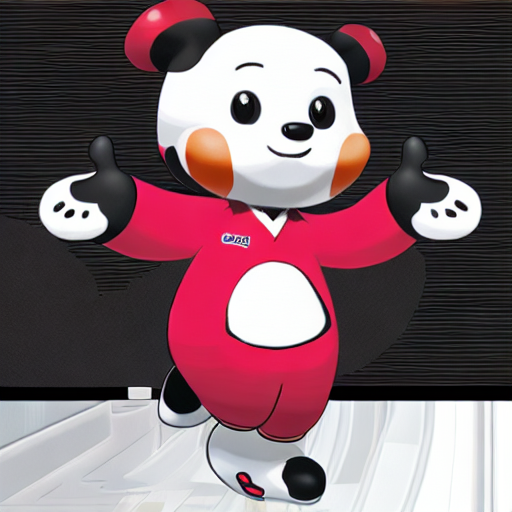

In [ ]:
pipeline.to(device);
pipeline_output = pipeline(["""
part 1 **
Generate a very cute teddybear-like trendy mascot image. Its body is white and it has point color in red. It reperesents a company related to big data analysis, so it should look smart and happy.

part 2 **
1.friendliness  2. innovation  3. analytical
"""])
pipeline_output.images[0]

### 파인튜닝 전 기본 스테이블 디퓨전 모델

  0%|          | 0/50 [00:00<?, ?it/s]

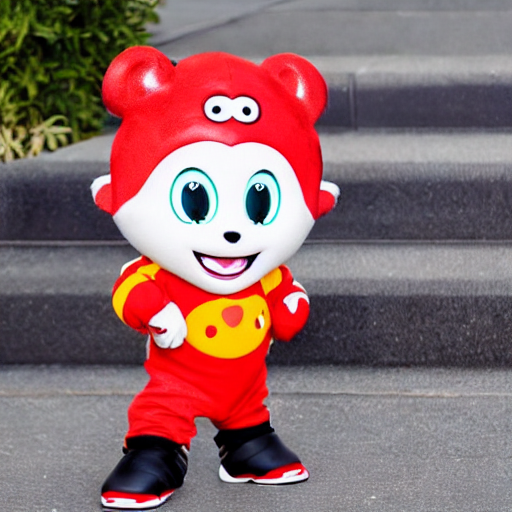

In [10]:
pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

pipeline_output = pipeline(["""
part 1 **
Generate a very cute teddybear-like trendy mascot image. Its body is white and it has point color in red. It reperesents a company related to big data analysis, so it should look smart and happy.

part 2 **
1.friendliness  2. innovation  3. analytical
"""])

pipeline_output.images[0]

## 참고 링크

- 허깅페이스 파인튜닝 도움말(스크립트 버전): https://huggingface.co/docs/diffusers/training/text2image

- 데이터 셋: https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions

- 파인튜닝 스크립트 소스: https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

- Pytorch AMP 도움말: https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html


- Pytorch AMP 블로그: https://pytorch.org/blog/what-every-user-should-know-about-mixed-precision-training-in-pytorch/